In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
con=sqlite3.connect('./amazon-fine-food-reviews/database.sqlite')
data=pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score !=3""",con)
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'
actualscore=data['Score']
positiveNegative=actualscore.map(partition)
data['Score']=positiveNegative
data.shape
data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [2]:
display=pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score !=3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [3]:
sorted_data=data.sort_values('ProductId',axis=0,ascending=True)

In [4]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final.shape

(364173, 10)

In [5]:
display=pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)


(364171, 10)


In [7]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [8]:
count_vect=CountVectorizer()
final_counts=count_vect.fit_transform(final['Text'].values)
type(final_counts)
final_counts.shape

(364171, 115281)

In [9]:
import re
import string
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop=set(stopwords.words('english'))
sno=nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned=re.sub(r'[?|\'|"|#]',r'',sentence)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print("***************************")
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dheer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'but', 'were', 'she', 'about', 'does', 'had', "isn't", 'have', 'be', 'should', "should've", "wouldn't", 'am', 'again', 'between', 'those', 'hasn', 'can', 'an', 'on', 'few', 'm', 'yours', 'own', 'which', 'doing', 'same', "it's", 'himself', 'above', 'themselves', 'wouldn', 'the', 've', 'their', 'when', 'against', 'too', "you're", 'at', 'nor', 'other', 'mightn', 'couldn', "hadn't", 'itself', 'won', 'then', 'very', 'just', "shouldn't", 'herself', 'before', 'd', "hasn't", 'for', 'if', "doesn't", 'as', 'than', 'no', 'ourselves', 'that', 'whom', "you'll", 'into', 'during', 'why', 'all', 'i', 'your', 'so', 'ours', 'wasn', "don't", 'her', 'further', 'there', "mustn't", 'because', "haven't", 'his', 'are', 'it', 'how', 'you', 'theirs', 'over', 'do', 'what', "you've", 'to', 's', 'don', 'ma', 'isn', "weren't", 'after', "shan't", 'from', 'up

In [10]:
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=' '
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha())& (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if(final['Score'].values)[i]=="positive":
                        all_positive_words.append(s)
                    if(final['Score'].values)[i]=="negative":
                        all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1
    
                    
    

In [11]:
final['CleanedText']=final_string
final.head(3)
conn=sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory=str
final.to_sql('Reviews',conn,schema=None, if_exists='replace')
con=sqlite3.connect("final.sqlite")
cleaned_data=pd.read_sql_query("Select * from Reviews",con)
cleaned_data.shape
data_pos=cleaned_data[cleaned_data["Score"]=="positive"].sample(n=1000)
data_neg=cleaned_data[cleaned_data["Score"]=="negative"].sample(n=1000)
final_2k=pd.concat([data_pos,data_neg])
final_2k.shape

(2000, 12)

In [26]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("common +ve:",freq_dist_positive.most_common(20))
print("common -ve:",freq_dist_negative.most_common(20))

common +ve: [(b'like', 139192), (b'tast', 127666), (b'good', 109015), (b'flavor', 108059), (b'love', 106919), (b'use', 103659), (b'great', 99172), (b'one', 95743), (b'product', 87578), (b'tri', 85873), (b'tea', 82368), (b'coffe', 77498), (b'make', 74955), (b'get', 72004), (b'food', 63791), (b'would', 55528), (b'time', 54207), (b'buy', 53719), (b'realli', 52653), (b'eat', 51577)]
common -ve: [(b'tast', 34400), (b'like', 32296), (b'product', 27885), (b'one', 20433), (b'flavor', 19460), (b'would', 17957), (b'tri', 17723), (b'use', 15270), (b'good', 14892), (b'coffe', 14578), (b'get', 13776), (b'buy', 13629), (b'order', 12811), (b'food', 12631), (b'dont', 11857), (b'tea', 11577), (b'even', 11084), (b'box', 10722), (b'amazon', 9927), (b'make', 9836)]


In [17]:
count_vect= CountVectorizer(ngram_range=(1,2))
final_bigram_counts=count_vect.fit_transform(final['Text'].values)
final_bigram_counts.shape

(364171, 2910192)

In [18]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
final_tf_idf=tf_idf_vect.fit_transform(final['Text'].values)


In [23]:
final_tf_idf.shape

(364171, 2910192)

In [24]:
features=tf_idf_vect.get_feature_names()
len(features)


2910192

In [22]:
features[100000:100010]


['ales until',
 'ales ve',
 'ales would',
 'ales you',
 'alessandra',
 'alessandra ambrosia',
 'alessi',
 'alessi added',
 'alessi also',
 'alessi and']

In [38]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)
    

In [19]:
print(final['Text'].values[0])
print("***********")
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
***********
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


In [22]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [23]:
words=list(w2v_model.wv.vocab)
print(len(words))


33546


In [25]:
w2v_model.wv.most_similar('tasty')

[('tastey', 0.9091671705245972),
 ('yummy', 0.8762150406837463),
 ('satisfying', 0.843543291091919),
 ('delicious', 0.8358434438705444),
 ('filling', 0.8261601328849792),
 ('flavorful', 0.8042966723442078),
 ('addicting', 0.79050612449646),
 ('nutritious', 0.7718136310577393),
 ('versatile', 0.7485423684120178),
 ('delish', 0.7424246668815613)]

In [26]:
w2v_model.wv.most_similar('like')

[('resemble', 0.7452789545059204),
 ('mean', 0.6636027693748474),
 ('dislike', 0.6575983166694641),
 ('prefer', 0.6511382460594177),
 ('overpower', 0.6088792085647583),
 ('think', 0.605532705783844),
 ('enjoy', 0.5925202965736389),
 ('gross', 0.5751219987869263),
 ('bother', 0.5735485553741455),
 ('miss', 0.5699315667152405)]

In [28]:
count_vect_feat=count_vect.get_feature_names()
#count_vect_feat.index('like')
print(count_vect_feat[64055])


like


In [44]:
sent_vectors=[]
for sent in list_of_sent:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for words in sent:
        try:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
        sent_vec/=cnt_words
        sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

        


NameError: name 'list_of_sent' is not defined

In [53]:
data_1000=sent_vectors[0:1000]
len(data_1000)

1000

In [42]:
labels=l.head(1000)
data_1000=sent_vectors.head(1000)

AttributeError: 'list' object has no attribute 'head'

In [12]:
final_2k['Time']=pd.to_datetime(final_2k["Time"],unit="s")
final_2k=final_2k.sort_values(by="Time")

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation

C:\Users\dheer\AppData\Local\Continuum\anaconda3\ANACONDA2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
def k_classfier_brute(x_tr,y_tr):
    mylist=list(range(0,50))

    neighbors=list(filter(lambda x:x%2!=0,mylist))

    cv_scores = []

    for k in neighbors:
        knn=KNeighborsClassifier(n_neighbors=k)
        scores=cross_val_score(knn,x_tr,y_tr,cv=10,scoring='accuracy')
        cv_scores.append(scores.mean())

    MSE=[1-x for x in cv_scores]

    optimal_k=neighbors[MSE.index(min(MSE))]

    print("optimal_k=%d"% optimal_k)

    plt.plot(neighbors,MSE)

    for xy in zip(neighbors,np.round(MSE,3)):
        plt.annotate('(%s,%s)'%xy,xy=xy,textcoords='data')

    plt.xlabel('Number of neighbors K')

    plt.ylabel("Mse errors")

    plt.show() 
    return optimal_k

In [14]:
x=final_2k["CleanedText"]
x.shape

(2000,)

In [15]:
y=final_2k["Score"]
y.shape

(2000,)

In [16]:
from sklearn.model_selection import train_test_split
x_tr,x_test,y_tr,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
#x_tr.shape
print(y_tr.shape,x_tr.shape,x_test.shape)


(1400,) (1400,) (600,)


In [18]:
bow=CountVectorizer()
x_tr=bow.fit_transform(x_tr)
x_tr

<1400x5405 sparse matrix of type '<class 'numpy.int64'>'
	with 44635 stored elements in Compressed Sparse Row format>

In [19]:
x_test=bow.transform(x_test)
x_test.shape

(600, 5405)

optimal_k=7


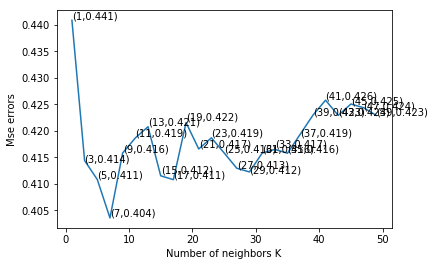

7


In [19]:
optimal_kbow=k_classfier_brute(x_tr,y_tr)
print(optimal_kbow)

In [20]:
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_kbow)
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)*100
print(acc)

57.333333333333336


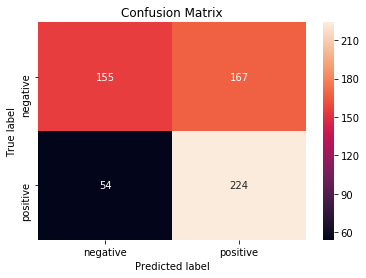

In [32]:
#confusion matrix to explain the performance
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test,pred)
class_label=["negative","positive"]
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [55]:
#tf-idf
from sklearn.model_selection import train_test_split
x_tr,x_test,y_tr,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
#x_tr.shape
print(y_tr.shape,x_tr.shape,x_test.shape)

tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
x_tr=tf_idf_vect.fit_transform(x_tr)
x_tr
x_test=tf_idf_vect.transform(x_test)
x_test.shape


(1400,) (1400,) (600,)


(600, 52156)

optimal_k=43


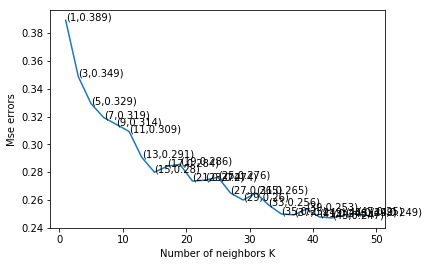

43


In [46]:
optimal_kbow=k_classfier_brute(x_tr,y_tr)
print(optimal_kbow)

In [47]:
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_kbow)
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)*100
print(acc)

69.83333333333334


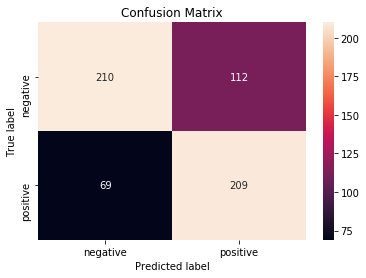

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test,pred)
class_label=["negative","positive"]
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [89]:
#word2vec
X=final_2k["Text"]
X.shape
y=final_2k["Score"]
from sklearn.model_selection import train_test_split
x_tr,x_test,y_tr,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
#x_tr.shape
print(y_tr.shape,x_tr.shape,x_test.shape,y_test.shape)



(1400,) (1400,) (600,) (600,)


In [90]:
import re
import string
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop=set(stopwords.words('english'))
sno=nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned=re.sub(r'[?|\'|"|#]',r'',sentence)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print("***************************")
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dheer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'but', 'were', 'she', 'about', 'does', 'had', "isn't", 'have', 'be', 'should', "should've", "wouldn't", 'am', 'again', 'between', 'those', 'hasn', 'can', 'an', 'on', 'few', 'm', 'yours', 'own', 'which', 'doing', 'same', "it's", 'himself', 'above', 'themselves', 'wouldn', 'the', 've', 'their', 'when', 'against', 'too', "you're", 'at', 'nor', 'other', 'mightn', 'couldn', "hadn't", 'itself', 'won', 'then', 'very', 'just', "shouldn't", 'herself', 'before', 'd', "hasn't", 'for', 'if', "doesn't", 'as', 'than', 'no', 'ourselves', 'that', 'whom', "you'll", 'into', 'during', 'why', 'all', 'i', 'your', 'so', 'ours', 'wasn', "don't", 'her', 'further', 'there', "mustn't", 'because', "haven't", 'his', 'are', 'it', 'how', 'you', 'theirs', 'over', 'do', 'what', "you've", 'to', 's', 'don', 'ma', 'isn', "weren't", 'after', "shan't", 'from', 'up

In [91]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim
i=0
list_of_sent_tr=[]
for sent in x_tr:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent_tr.append(filtered_sentence)
    

In [92]:
w2v_model=gensim.models.Word2Vec(list_of_sent_tr,min_count=5,size=50,workers=4)

In [93]:
w2v=w2v_model[w2v_model.wv.vocab]
print(w2v.shape)



(2013, 50)


C:\Users\dheer\AppData\Local\Continuum\anaconda3\ANACONDA2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [94]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim
i=0
list_of_sent_test=[]
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent_test.append(filtered_sentence)
    

In [95]:

print(len(list_of_sent_test))


600


In [96]:
#average_word 2 vec
w2v_models=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)
w2v_models.wv.most_similar('like')
#w2v=w2v_models[w2v_model.wv.vocab]
w2v.shape

(2013, 50)

C:\Users\dheer\AppData\Local\Continuum\anaconda3\ANACONDA2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(1107, 50)

In [97]:
sent_vectors_test=[]
for sent1 in list_of_sent_test:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent1:
        try:
            vec=w2v_models.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    sent_vec /=cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

600
50


C:\Users\dheer\AppData\Local\Continuum\anaconda3\ANACONDA2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [98]:
sent_vectors=[]
for sent1 in list_of_sent_tr:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent1:
        try:
            vec=w2v_models.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    sent_vec /=cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

1400
50


In [99]:
x_tr=sent_vectors
x_test=sent_vectors_test

In [80]:
def k_classfier_brute(x_tr,y_tr):
    mylist=list(range(0,50))

    neighbors=list(filter(lambda x:x%2!=0,mylist))

    cv_scores = []

    for k in neighbors:
        knn=KNeighborsClassifier(n_neighbors=k)
        scores=cross_val_score(knn,x_tr,y_tr,cv=10,scoring='accuracy')
        cv_scores.append(scores.mean())

    MSE=[1-x for x in cv_scores]

    optimal_k=neighbors[MSE.index(min(MSE))]

    print("optimal_k=%d"% optimal_k)

    plt.plot(neighbors,MSE)

    for xy in zip(neighbors,np.round(MSE,3)):
        plt.annotate('(%s,%s)'%xy,xy=xy,textcoords='data')

    plt.xlabel('Number of neighbors K')

    plt.ylabel("Mse errors")

    plt.show() 
    return optimal_k

optimal_k=5


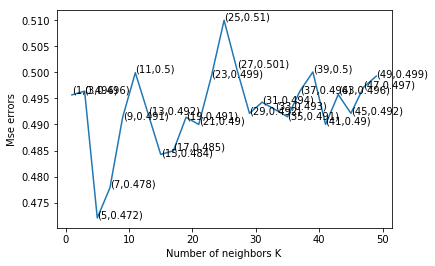

In [81]:
knn_avgw2v=k_classfier_brute(x_tr,y_tr)

In [48]:
knn_optimal=KNeighborsClassifier(n_neighbors=knn_avgw2v)
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc1=accuracy_score(y_test,pred)*100
print(acc1)


55.50000000000001


In [49]:
cm=confusion_matrix(y_test,pred)
cm


array([[181, 136],
       [131, 152]], dtype=int64)

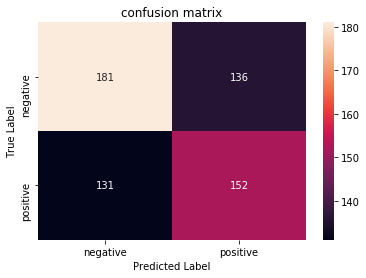

In [53]:
class_label=["negative","positive"]
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [102]:
#tf-idf weighted w2v
tfidf_feat=tf_idf_vect.get_feature_names()
tfidf_sent_vectors=[]
row=0
for sent in list_of_sent_tr:
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent:
        try:
            vec=w2v_model.wv[word]
            tfidf=final_tf_idf[row,tfidf_feat.index(word)]
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
        except:
            pass
    sent_vec/=weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row+=1

C:\Users\dheer\AppData\Local\Continuum\anaconda3\ANACONDA2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [103]:
len(tfidf_sent_vectors)

1400

In [104]:
x_tr=tfidf_sent_vectors

In [105]:
tfidf_feat=tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test=[]
row=0
for sent in list_of_sent_test:
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent:
        try:
            vec=w2v_model.wv[word]
            tfidf=final_tf_idf[row,tfidf_feat.index(word)]
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
        except:
            pass
    sent_vec/=weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1

C:\Users\dheer\AppData\Local\Continuum\anaconda3\ANACONDA2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [106]:
len(tfidf_sent_vectors_test)

600

In [107]:
x_test=tfidf_sent_vectors_test

In [108]:
x_tr=np.nan_to_num(x_tr)


In [109]:
x_test=np.nan_to_num(x_test)

optimal_k=3


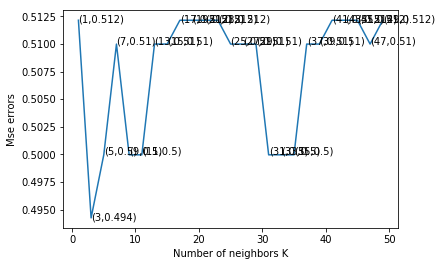

3

In [70]:
optimal_ktfidf=k_classfier_brute(x_tr,y_tr)
optimal_ktfidf

In [71]:
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_ktfidf)
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc2=accuracy_score(y_test,pred)*100
print(acc2)


47.16666666666667


In [72]:
cm=confusion_matrix(y_test,pred)
cm

array([[  0, 317],
       [  0, 283]], dtype=int64)

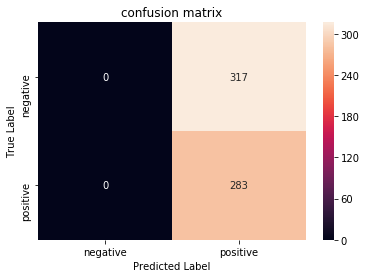

In [73]:
class_label=["negative","positive"]
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt="d")
plt.title("confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [74]:
#observations refer to kaggle


In [56]:
x=final_2k['CleanedText']
y=final_2k["Score"]


In [42]:
from sklearn.model_selection import train_test_split
x_tr,x_test,y_tr,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
#x_tr.shape
print(y_tr.shape,x_tr.shape,x_test.shape)


(1400,) (1400,) (600,)


In [37]:
bow=CountVectorizer()
x_tr=bow.fit_transform(x_tr)

In [38]:
x_test=bow.transform(x_test)

In [40]:
#LOGISTIC REGRESSION
#BOW
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV 
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
#data=load_breast_cancer()
tuned_para=[{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
#x_tr,x_test,y_tr,y_test=train_test_split(data.data,data.target,test_size=0.5,random_state=0)
model=GridSearchCV(LogisticRegression(),tuned_para,scoring='accuracy')
model.fit(x_tr,y_tr)
print(model.best_estimator_)
print(model.score(x_test,y_test)*100)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
81.5


In [43]:
#tfidf
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
x_tr=tf_idf_vect.fit_transform(x_tr)
x_tr
x_test=tf_idf_vect.transform(x_test)
x_test.shape


(600, 48039)

In [44]:
#lR-tfidf 
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV 
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
#data=load_breast_cancer()
tuned_para=[{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
#x_tr,x_test,y_tr,y_test=train_test_split(data.data,data.target,test_size=0.5,random_state=0)
model=GridSearchCV(LogisticRegression(),tuned_para,scoring='accuracy')
model.fit(x_tr,y_tr)
print(model.best_estimator_)
print(model.score(x_test,y_test)*100)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
83.33333333333334


In [57]:
#lr for w2v
x_tr=sent_vectors
x_test=sent_vectors_test

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV 
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
#data=load_breast_cancer()
tuned_para=[{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
#x_tr,x_test,y_tr,y_test=train_test_split(data.data,data.target,test_size=0.5,random_state=0)
model=GridSearchCV(LogisticRegression(),tuned_para,scoring='accuracy')
model.fit(x_tr,y_tr)
print(model.best_estimator_)
x_test=np.nan_to_num(x_test)
print(model.score(x_test,y_test)*100)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
68.0


In [112]:
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV 
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
#data=load_breast_cancer()
tuned_para=[{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
#x_tr,x_test,y_tr,y_test=train_test_split(data.data,data.target,test_size=0.5,random_state=0)
model=GridSearchCV(LogisticRegression(penalty='l1'),tuned_para,scoring='accuracy')
model.fit(x_tr,y_tr)
print(model.best_estimator_)
#x_test=np.nan_to_num(x_test)
print(model.score(x_test,y_test)*100)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
49.666666666666664
